<a href="https://colab.research.google.com/github/eyaler/workshop/blob/master/output/nn_3_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. How to train and test your network (CIFAR)

In [1]:
%tensorflow_version 1.x
!pip install keras==2.2.5
!pip install livelossplot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import Input, Model
from keras.layers import Dense, Dropout
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from livelossplot import PlotLossesKeras
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
!nvidia-smi -L

TensorFlow 1.x selected.
     |████████████████████████████████| 337kB 4.6MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Using TensorFlow backend.


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-220ba38f-03b9-14b0-4730-be24eccbfa8c)


In [2]:
# set random seeds for more reproducible results
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(43)

In [3]:
# load dataset
#(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = mnist.load_data()
(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = cifar10.load_data()
print(raw_x_train.shape, raw_y_train.shape)
if len(raw_x_train.shape)==4:
    raw_x_train = np.mean(raw_x_train, axis=-1)
    raw_x_test = np.mean(raw_x_test, axis=-1)
train_size = len(raw_y_train)
test_size = len(raw_y_test)
xdim = raw_x_train.shape[1]
ydim = raw_x_train.shape[2]
print(raw_x_train.dtype, raw_y_train.dtype)

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1)
float64 uint8


[[ 61.33333333  44.66666667  47.         ... 132.66666667 126.33333333
  125.        ]
 [ 18.66666667   0.           8.66666667 ...  88.66666667  84.
   88.66666667]
 [ 23.33333333   7.66666667  28.         ...  84.          84.66666667
   74.66666667]
 ...
 [158.         129.33333333 128.33333333 ... 121.          31.33333333
   35.66666667]
 [138.33333333 112.66666667 120.         ... 142.          64.33333333
   56.66666667]
 [145.66666667 130.33333333 136.         ... 180.         117.66666667
   95.66666667]]
[6]


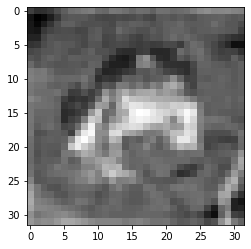

In [4]:
print(raw_x_train[0])
print(raw_y_train[0])
plt.imshow(raw_x_train[0], cmap='gray')

In [5]:
print(np.min(raw_x_train), np.max(raw_x_train), np.median(raw_x_train))
print(np.unique(raw_y_train, return_counts=True))
print(np.unique(raw_y_test, return_counts=True))

0.0 255.0 116.33333333333333
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


In [6]:
n_classes = len(np.unique(raw_y_test))
x_train, y_train = shuffle(raw_x_train, raw_y_train, random_state=44)
x_train = x_train.reshape((train_size, -1))/255
x_test = raw_x_test.reshape((test_size, -1))/255
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(raw_y_test, n_classes)
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

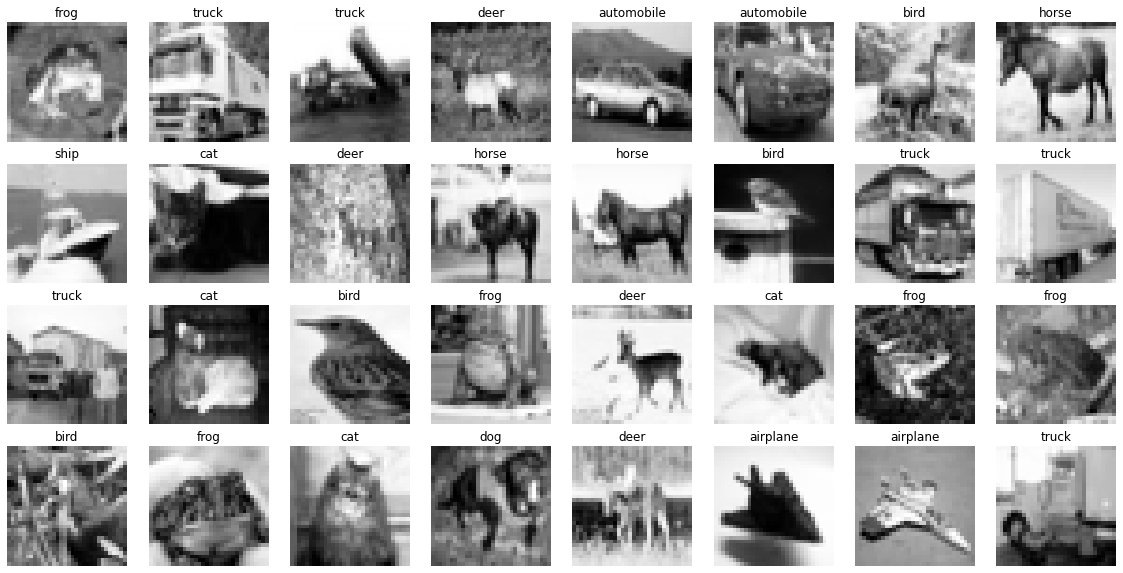

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid

#helper function to plot in grids
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(label_list[i])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

show_grid(raw_x_train[:32],4,8,label_list=[class_names[i] for i in np.squeeze(raw_y_train[:32])],show_labels=True,figsize=(20,10))

In [8]:
dropout_prob = 0.5

def get_model():
    inputs = Input(shape=(xdim*ydim,))
    f = Dense(1024, activation='relu')(inputs)
    f = Dropout(dropout_prob)(f)
    f = Dense(1024, activation='relu')(f)
    f = Dropout(dropout_prob)(f)
    f = Dense(256, activation='relu')(f)
    f = Dropout(dropout_prob)(f)
    outputs = Dense(n_classes, activation='softmax')(f)
    return Model(inputs=inputs, outputs=outputs)

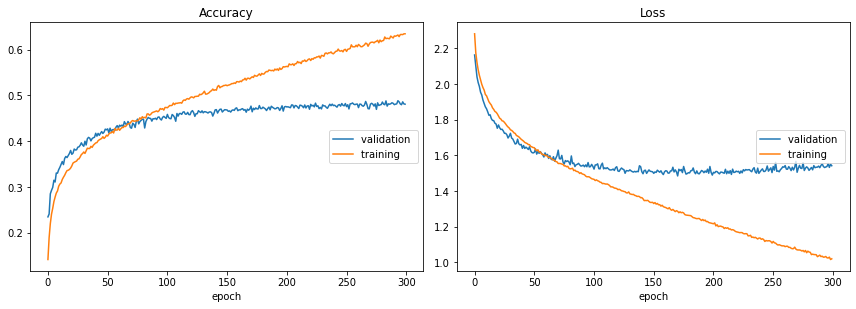

Accuracy
	validation       	 (min:    0.235, max:    0.488, cur:    0.481)
	training         	 (min:    0.141, max:    0.634, cur:    0.634)
Loss
	validation       	 (min:    1.485, max:    2.163, cur:    1.542)
	training         	 (min:    1.016, max:    2.282, cur:    1.020)


In [9]:
model = get_model()
print(model.summary())
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=300, validation_split=0.2, callbacks=[PlotLossesKeras()])

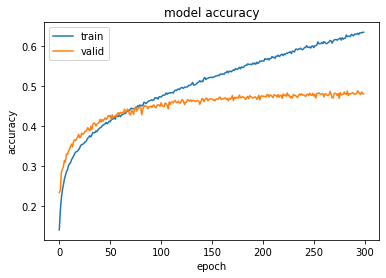

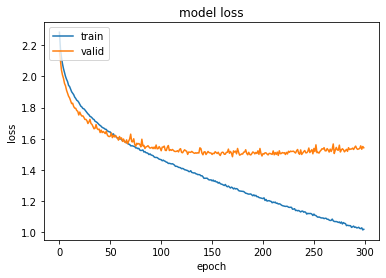

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix
loss, acc = model.evaluate(x=x_test, y=y_test)
print(loss, acc)
targets = np.argmax(y_test, axis=-1)
probabilities = model.predict(x=x_test)
predictions = np.argmax(probabilities, axis=-1)
cm = confusion_matrix(y_true=targets, y_pred=predictions)
print(cm)

10000/10000 [==============================] - 0s 38us/step
1.521946258544922 0.4806
[[405  49  92  14  99  10  76  20 192  43]
 [ 17 621   5  19  23   6  80  17  74 138]
 [ 49  21 356  76 173  79 147  38  40  21]
 [ 23  26  78 261 129 149 205  51  24  54]
 [ 28  16 140  45 449  43 162  57  46  14]
 [ 16  15  87 156 114 375 123  68  22  24]
 [  8  36  70  47  96  21 652  19  21  30]
 [ 14  27  44  62 139  69  54 524  24  43]
 [ 55  91  16  33  45  14  49  11 637  49]
 [ 21 198  18  38  35  15  50  24  75 526]]


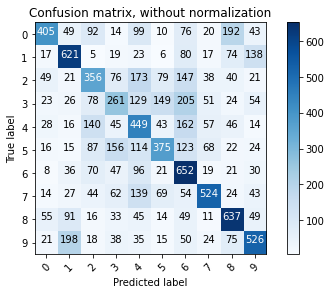

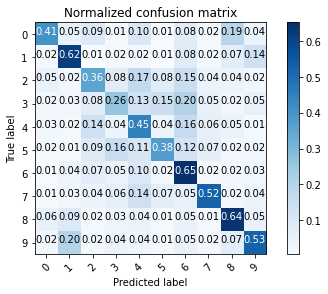

In [12]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    np.set_printoptions(precision=2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

classes = np.arange(n_classes)
plot_confusion_matrix(cm, classes=classes)
plot_confusion_matrix(cm, classes=classes, normalize=True)

In [13]:
from sklearn.metrics import classification_report
report = classification_report(y_true=targets, y_pred=predictions, labels=classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.64      0.41      0.50      1000
  automobile       0.56      0.62      0.59      1000
        bird       0.39      0.36      0.37      1000
         cat       0.35      0.26      0.30      1000
        deer       0.34      0.45      0.39      1000
         dog       0.48      0.38      0.42      1000
        frog       0.41      0.65      0.50      1000
       horse       0.63      0.52      0.57      1000
        ship       0.55      0.64      0.59      1000
       truck       0.56      0.53      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.48     10000
weighted avg       0.49      0.48      0.48     10000



In [14]:
# top errors
from sklearn.metrics import log_loss
max_probs = np.max(probabilities, axis=-1)
losses = [log_loss(y_true=y, y_pred=prob, eps=1e-7) for y,prob in zip(y_test,probabilities)]
print('loss\tindex\ttrue\tpredicted\tprobability')
top_errors = sorted(list(zip(losses, np.arange(test_size), [class_names[i] for i in targets], [class_names[i] for i in predictions], max_probs)), reverse=True)[:32]
titles = []
inds = []
for i,error in enumerate(top_errors):
    titles.append('%s -> %s'%(error[2],error[3]))
    inds.append(error[1])
    if i<10:
        print('%.04f\t%d\t%s\t%s\t\t%.04f'%error)
        #plt.figure()
        #plt.imshow(raw_x_test[error[1]], cmap='gray')

loss	index	true	predicted	probability
1.4456	7119	dog	airplane		0.9114
1.3210	2323	ship	automobile		0.9977
1.3177	5175	frog	automobile		0.9877
1.2627	4748	airplane	automobile		0.9889
1.2535	9529	truck	dog		0.5893
1.2287	2895	horse	dog		0.9722
1.2264	8156	airplane	automobile		0.9761
1.2030	9930	ship	cat		0.4788
1.1966	5496	deer	frog		0.9868
1.1951	8385	truck	automobile		0.9960


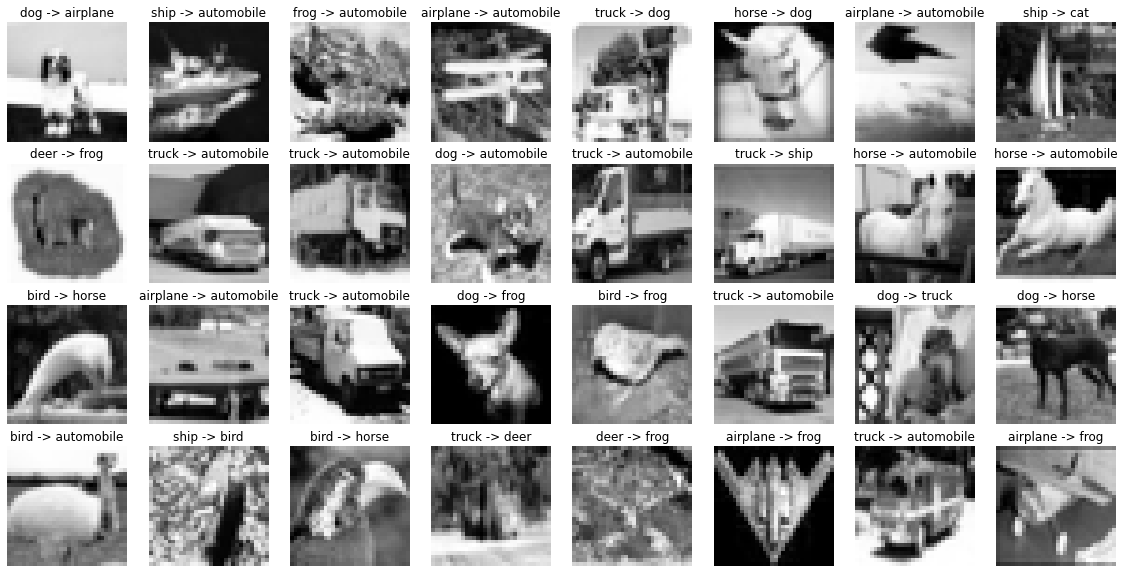

In [15]:
show_grid(raw_x_test[inds[:32]],4,8,label_list=titles[:32],show_labels=True,figsize=(20,10))